## 1. Importe und Checks

In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import re #Regular Expressions für die Entfernung von HTML-Tags etc.
from pathlib import Path
from scipy.stats import skew
import matplotlib.pyplot as plt
import numpy as np

print("pandas:", pd.__version__)
print("pyarrow:", pa.__version__)


pandas: 2.2.3
pyarrow: 21.0.0


## 2. Einlesen der Daten

In [2]:

DATA_DIR = Path(".")   # aktueller Ordner
PATH_TXT = DATA_DIR / "prd_txt.parquet"
PATH_TYP = DATA_DIR / "prd_typ.parquet"

for p in [PATH_TXT, PATH_TYP]:
    print(p, "exists:", p.exists())

prd_txt.parquet exists: True
prd_typ.parquet exists: True


## Fragen 
**1. Welche Datentypen haben die einzelnen Spalten?**  
*Außerdem: Wie groß sind die Dateien überhaupt und wieviele Instanzen liegen vor?*

In [3]:
# %% [markdown]
# ## 3. Check Anzahl der Zeilen & komplettes Einlesen

# %%
pf_txt = pq.ParquetFile(PATH_TXT)
print("prd_txt.parquet — Row groups:", pf_txt.num_row_groups)
print(pf_txt.schema)
print("Rows (from metadata):", pf_txt.metadata.num_rows)

pf_typ = pq.ParquetFile(PATH_TYP)
print("\nprd_typ.parquet — Row groups:", pf_typ.num_row_groups)
print(pf_typ.schema)
print("Rows (from metadata):", pf_typ.metadata.num_rows)

# 1) Komplettes Einlesen der Textdaten
tbl_txt = pq.read_table(PATH_TXT, columns=["produkt_id", "variation_id", "beschreibung"])
df_txt = tbl_txt.to_pandas(types_mapper=pd.ArrowDtype)

# 2) Erste Checks
print("Rows insgesamt:", len(df_txt))
display(df_txt.head())
display(df_txt.dtypes)

# 3) Describe Methode
df_txt.describe()

prd_txt.parquet — Row groups: 3
required group field_id=-1 schema {
  optional binary field_id=-1 produkt_id (String);
  optional binary field_id=-1 variation_id (String);
  optional binary field_id=-1 beschreibung (String);
  optional int64 field_id=-1 __index_level_0__;
}

Rows (from metadata): 2190338

prd_typ.parquet — Row groups: 3
required group field_id=-1 schema {
  optional binary field_id=-1 produkt_id (String);
  optional binary field_id=-1 produkt_klasse (String);
}

Rows (from metadata): 2863866
Rows insgesamt: 2190338


,produkt_id,variation_id,beschreibung
0,S0O0Z0F3,S0O0Z0F3XNK8,-
1,S0Z0H0DJ,S0Z0H0DJYFCH,<h2>Home Wohnideen Schiebevorhang Digitaldruck...
2,S0J1B062,S0J1B0620136,"Leggings für alle, die wissen, worauf es ankom..."
3,S0I010JR,S0I010JRN3AA,<p><strong>Bruchfeste Apple iPhone 6 Silikon H...
4,S041B01K,S041B01K7KAI,Maxi-Rock aus Leinen in A-Linie mit Wickelopti...


produkt_id      string[pyarrow]
variation_id    string[pyarrow]
beschreibung    string[pyarrow]
dtype: object

,produkt_id,variation_id,beschreibung
count,2190338,2190338,1996797
unique,1129830,2190338,922474
top,S0E1A0R3,S0O0Z0F3XNK8,-
freq,162,1,94834




**2. Gibt es fehlende Werte? Falls ja, wie gehen Sie damit um?** 
Im prd.txt-File gibt es in 193.541 Instanzen keine Beschreibung. Diese Daten können m.E. nicht für das Training verwendet werden. Interessant wäre es noch, wie wir mit sehr kurzen Texten umgehen.


In [5]:
print("\nFehlende Werte je Spalte:")
df_txt["desc_len"] = df_txt["beschreibung"].astype("string").str.len() #Erzeugung der Spalte desc_len in df_txt
display(df_txt.isna().sum().drop("desc_len"))
df_txt.isna().any().drop("desc_len")


Fehlende Werte je Spalte:


produkt_id           0
variation_id         0
beschreibung    193541
dtype: int64

produkt_id      False
variation_id    False
beschreibung     True
dtype: bool

**3. Gibt es Extremwerte?**

In [6]:
# 3) Textlängen als Schnell-Heuristik

print("\nTextlängen-Statistik:")
display(df_txt["desc_len"].describe(percentiles=[0.5, 0.9, 0.99]))

# Anteil kurzer Texte
short_texts = (df_txt["desc_len"] < 10).sum()
short_texts_ratio = short_texts / len(df_txt)
print(f"Die Anzahl von Texten mit weniger als zehn Zeichen beträgt: {short_texts}. "
      f"Dies entspricht einem Anteil von {short_texts_ratio:.2%}.")

# Anteil sehr kurzer Texte 
very_short_texts = (df_txt["desc_len"] == 1).sum()
very_short_texts_ratio = very_short_texts / len(df_txt)
print(f"Die Anzahl von Texten mit genau einem Zeichen beträgt: {very_short_texts}. "
      f"Dies entspricht einem Anteil von {short_texts_ratio:.2%}.")


Textlängen-Statistik:


count     1996797.0
mean     741.595983
std      861.822553
min             1.0
50%           565.0
90%          1585.0
99%          2875.0
max        186751.0
Name: desc_len, dtype: Float64

Die Anzahl von Texten mit weniger als zehn Zeichen beträgt: 96262. Dies entspricht einem Anteil von 4.39%.
Die Anzahl von Texten mit genau einem Zeichen beträgt: 95531. Dies entspricht einem Anteil von 4.39%.


**Wie ist die Schiefe der Textlängen-Verteilung?**

In [7]:
from scipy.stats import skew
skewness = skew(df_txt["desc_len"].dropna())
print("Skewness:", skewness)

#Hier möchte ich noch eine Interpretation für die Schiefe der Verteilung einbauen

Skewness: 74.01428411132152


**4. Beinhalten die Beschreibunge unerwartete oder unnötige Zeichen?**

In [8]:
print (df_txt["beschreibung"][1])
print (df_txt["beschreibung"][:10])

<h2>Home Wohnideen Schiebevorhang Digitaldruck Bambus-Optik &#34;Eucalia&#34; 260 x 60 cm Grau</h2><br /><b>Kurzbeschreibung</b><p>- VISION S -<br /> Dieser Schiebevorhang mit dem digitalen Fotodruck &#34;EUCALIA&#34; ergibt durch das fotorealistische Motiv einen tollen Effekt an Ihren Fenstern. Der Schiebevorhang wurde digital bedruckt und zeigt so seine Brillanz auf dem HALBTRANSPARENTEM STOFF in BAMBUS-OPTIK mit leichten QUEREFFEKTEN. Die Seiten wurden durch spezielle Lasertechnik geschnitten. Inkl. Paneelwagen mit Röllchen und X-Gleitern für alle gängigen Gardinenschienen. Durch die hochwertige Aluminium-Klemmleiste haben Sie die Möglichkeit den Schiebevorhang auf jede beliebige Höhe zu kürzen. Material: 100% Polyester. Dieser Schiebevorhang lässt sich sehr gut mit weiteren Schiebegardinen kombinieren.</p><br /><b>Zusammenfassung</b><ul><li> 1x Home Wohnideen Schiebevorhang Digitaldruck Bambus-Optik &#34;Eucalia&#34; 260 x 60 cm Grau</li><li> Farbenfrohe Designs</li><li> hochwertig

Die Texte enthalten auffallend viele HTML-Tags. Diese könnte man m.E. rausfiltern

**5. Enthalten die Daten Duplikate?**

Nach meinem Verständnis ist die ID Variation ID letztlich der "echte" unique identifier, über den gemerged werden müsste. Pro Produkt ID kann es mehrere Variation IDs geben (z.B. Handyhüllen in unterschiedlichen Farben)

In [10]:
# Labels (erste RowGroup)
tbl_typ = pq.ParquetFile(PATH_TYP).read()
df_typ = tbl_typ.to_pandas(types_mapper=pd.ArrowDtype) #Conversion von pyarrow.parquet zu pandas zur Datenanalyse
print(f'Die Anzahl der Einträge für Produkt-ID in der Typ-Datei beträgt {df_typ.shape[0]:,}. Die Anzahl der eindeutigen Produkt-IDs beträgt {df_typ["produkt_id"].nunique():,}.')

Die Anzahl der Einträge für Produkt-ID in der Typ-Datei beträgt 2,863,866. Die Anzahl der eindeutigen Produkt-IDs beträgt 2,863,866.


In [11]:
print(f'Die Anzahl der Einträge für Produkt-ID in der Typ-Datei beträgt {df_txt.shape[0]:,}. Die Anzahl der eindeutigen Beschreibungen beträgt {df_txt["beschreibung"].nunique():,}.')

Die Anzahl der Einträge für Produkt-ID in der Typ-Datei beträgt 2,190,338. Die Anzahl der eindeutigen Beschreibungen beträgt 922,474.


EIne verwandte Frage ist, ob wir Produkt-IDs mit unterschiedlichen Klassenzuordnungen haben:

In [12]:
multi = (df_typ.groupby("produkt_id")["produkt_klasse"]
         .nunique(dropna=True).gt(1).sum())
print("Produkt-IDs mit >1 unterschiedlicher Klasse:", multi)

Produkt-IDs mit >1 unterschiedlicher Klasse: 0


## Vorverarbeitung der Beschreibungen ## 

In [43]:
df_txt["beschreibung"] = (
    df_txt["beschreibung"]
    .str.replace(r"<.*?>", "", regex=True)
    .str.replace("&amp;", "und")
    .str.replace("&#43;", "und")
    .str.replace(",", "")
    .str.replace(".", "")
    .str.replace("!", "")
    .str.replace(";", "")
    .str.replace("?", "")
    .str.replace(":", "")
    .str.replace("&#34", "") # Entfernung von Anführungszeichen
    .str.lower()
)

In [44]:
display(df_txt.iloc[0]["beschreibung"])
display(df_txt.iloc[11]["beschreibung"])
display(df_txt.iloc[21]["beschreibung"])
display(df_txt.iloc[31]["beschreibung"])
display(df_txt.iloc[41]["beschreibung"])
display(df_txt.iloc[5]["beschreibung"])
display(df_txt.iloc[61]["beschreibung"])
display(df_txt.iloc[111231]["beschreibung"])
display(df_txt.iloc[42]["beschreibung"])
display(df_txt.iloc[491827]["beschreibung"])


'-'

'das top bringt mit der edlen spitze feminine eleganz in deinen kleiderschrank das romantische oberteil punktet mit zarter blumenspitze und kordelstickereien zum echten hingucker wird das schmal geschnittene spitzentop besonders durch die durchbrochene transparente optik unerwünschte einblicke werden dank der blickdichten unterfütterung vermieden'

'das wandbild mit dem motiv metropole skyline abstrakte collage des künstlers nettesart überzeugt durch originalgetreue druckqualität und hochwertige basismaterialen die modernen digitaldruckverfahren sorgen für kräftige farben und eine langlebige farbechtheit das motiv des künstlers nettesart wird ihnen dadurch wie abgebildet nach hause geliefert entscheiden sie sich für eine produktart die zu ihrem einrichtungsstil passt und ihren ansprüchen erfüllt die detaillierten merkmale unserer alubilder leinwandbilder poster und wandaufkleber (vinyl oder vliesstoff) können sie den produkteigenschaften nachlesenprodukteigenschaftenleinwandbildleinwand auf 2 cm keilrahmen gespannt - fertig zum aufhängenstrukturierte und blickdichte leinwandstruktur in seitenmatter optikuv-beständiger und hochaufgelöster digitaldruck in künstlerqualitätbedruckter seitenrand mit gespiegeltem motivinkl keile zum nachspannenhinweis wandschrauben oder dübel sind nicht enthalten posterpremium-papier in 210 g/m²kunstdr

'bed_64482_queen_deset enthält 1 tagesdecke (220 cm breite x 220 cm länge) und 2 kissenbezüge (75 cm breite x 50 cm länge) eine moderne alternative zum traditionellen klassiker kann auch im sommer als decke verwendet werden hergestellt aus sehr strapazierfähigem und nachhaltigem material das super weich und luftdurchlässig ist der stoff ist langlebig und umweltfreundlich keine schädlichen farbstoffe es wurden nur ökologisch freundliche tinten verwendet die farben werden dank neuer digitaler druckmethoden nicht verblassen wählen sie aus verschiedenen farbpaletten und unseren einzigartigen designs welche perfekt zu ihnen passen mit tausenden verschiedenen designs sind unsere produkte eine wunderbare geschenkidee in unseren otto shop finden sie das was sie suchen die hochwertige qualität unserer einzigartigen produkte wird sie und ihre familie werden langfristig erfreuen die größen können gering abweichen (1-2 cm) wir bemühen uns möglichst realistische vorschaubilder auszusuchen je nach b

'perfekt für business-reisen das traveller-sakko von james zeichnet sich durch das praktische taschen-ensemble und die knitterarme qualität aus'

'vielseitig laptoptasche von timbuk2 mit vielen sortierhilfen quergurt zur stabilisierung beim radfahren gepolstertem fach für laptops und reflektierenden details'

'ein klassischer schnitt trifft auf einen modischen print beim shirt big fishing alpine blue von ahorn sportswear das schicke oberteil ist außerdem mit lycrabündchen und einem nackenband ausgestattet sie sorgen für formstabilität elastizität und hohen tragekomfort für letzteres ist auch die verarbeitung aus 100 % reiner baumwolle verantwortlichmaterial 100% baumwolle'

'passender aufdruck zur fußball-wm brasilien vintage auf der suche nach einem coolen motiv oder aufdruck zum thema fußball brasilien vintage eignet sich perfekt zu der fußball-wm ist für viele ein highlight – wenn im sommer die deutsche mannschaft wieder auf dem platz steht das coole motiv zum thema brasilien vintage trifft genau ins schwarze um deinem nachwuchs eine freude zu machen kombiniert werden flagge und brasilien-flagge zum angesagten vintage-look das perfekte motiv zum thema fußball länder der aufdruck brasilien vintage bringt dich mit sicherheit zum strahlen mit unserem schnellen versand und der tollen qualität konnten wir bisher zahlreiche kunden zufrieden stellen printed in germany die textilien werden ausschließlich mit designs von ausgebildeteten grafikerinnen und grafikern bedruckt die verwendete farbe wird direkt auf die textilien gedruckt und ist somit besonders deckend damit ein perfektes druckergebnis erzielt wird also warte nicht länger – denn als echter fan darf d

'legeres basic für die freizeit das boss poloshirt aus reiner baumwolle das schmal geschnittene herren-polo zeigt sich mit gerippten ärmelbündchen und logo-applikation auf der brustsportive akzente setzt der struktur-streifen am kragen das gewaschene finish verleiht dem stückgefärbten shirt eine lässige optik kombinieren sie den style je nach anlass mit einer chino einer jeans oder shorts  \xa0 '

'behalte deinen fokus von der aufwärmrunde bis zum zielsprint dieser laufschuh für männer verfügt über ein nahtloses obermaterial das für einen reibungsfreien sitz und leichten support sorgt das webmaterial im mittelfußbereich gibt dir perfekten halt'

## Begrenzung der Textlängen ##

count     1996797.0
mean     666.056124
std      536.525731
min             0.0
50%           527.0
90%          1391.0
99%          2338.0
max          5000.0
Name: desc_len, dtype: double[pyarrow]


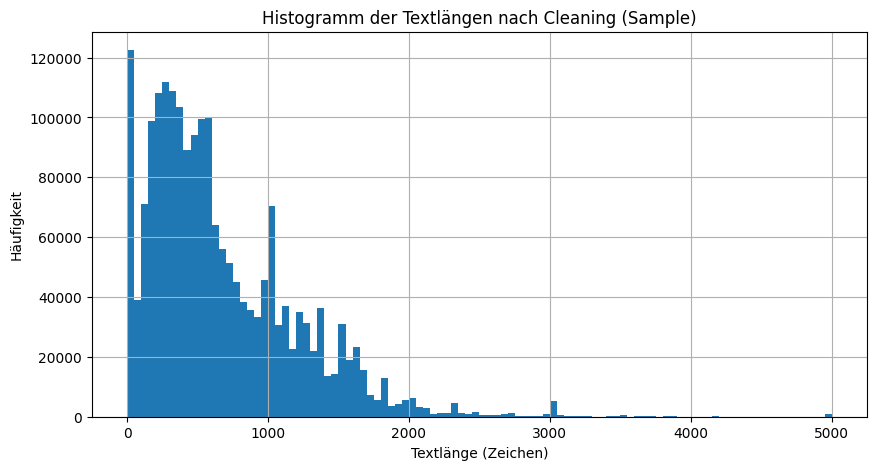

count     1996797.0
mean     666.056124
std      536.525731
min             0.0
50%           527.0
90%          1391.0
99%          2338.0
max          5000.0
Name: desc_len, dtype: double[pyarrow]


In [45]:
# 1) Fehlende Texte entfernen
df_txt_clean = df_txt.dropna(subset=["beschreibung"]).copy()

# 2) Texte auf 5000 Zeichen begrenzen
df_txt_clean = df_txt.dropna(subset=["beschreibung"]).copy()
df_txt_clean["beschreibung"] = df_txt_clean["beschreibung"].str[:5000]

# Neue Längen
df_txt_clean["desc_len"] = df_txt_clean["beschreibung"].str.len()
print(df_txt_clean["desc_len"].describe(percentiles=[0.5, 0.9, 0.99]))

# Vergleich Histogramm nach Cleaning
import matplotlib.pyplot as plt
df_txt_clean["desc_len"].hist(bins=100, figsize=(10,5))
plt.xlabel("Textlänge (Zeichen)")
plt.ylabel("Häufigkeit")
plt.title("Histogramm der Textlängen nach Cleaning (Sample)")
plt.show()

# 3) Längen nochmal prüfen
df_txt_clean["desc_len"] = df_txt_clean["beschreibung"].str.len()
print(df_txt_clean["desc_len"].describe(percentiles=[0.5, 0.9, 0.99]))


## 4. Labelverteilung 

In [ ]:


print("Rows im Label-Sample:", len(df_typ)) #Anzahl der Zeilen > 1 Mio. 
display(df_typ.head()) #Zeige die ersten 5 Zeilen an (5 ist Standardeinstellung für die head()-Funktion)

# Anzahl unterschiedlicher Klassen
n_classes = df_typ["produkt_klasse"].astype("string").nunique(dropna=True)
print("Anzahl unterschiedlicher Klassen:", n_classes)

# Klassenverteilung (Top 20)
vc = df_typ["produkt_klasse"].astype("string").value_counts(dropna=False)
display(vc.head(20))

vc_rel = vc / vc.sum()
type(vc_rel)
vc_rel.head()



Rows im Label-Sample: 2863866


,produkt_id,produkt_klasse
0,S0C1K0CL,Netzteile
1,S0T110ZP,Hosen
2,1319960810,Hartbodenbeläge
3,S0Y0R0EW,Sitzmöbel-Sets
4,S05180NJ,Hüllen


Anzahl unterschiedlicher Klassen: 1738


produkt_klasse
Schutzfolien          210478
Schuhe                161827
Hüllen                154191
Shirts                111593
Arbeitsspeicher       102618
Fahrradhalterungen     82313
Taschen                78193
Teppiche               65570
Hosen                  64761
Akkumulatoren          60304
Leuchten               51895
Jacken                 47916
Duschvorhänge          47820
Bilder                 44739
Kleider                38489
Gardinen               37628
Tischdecken            36577
Aufbewahrungsboxen     36152
Kissen                 35713
Halsketten             30448
Name: count, dtype: Int64

produkt_klasse
Schutzfolien       0.073494
Schuhe             0.056506
Hüllen              0.05384
Shirts             0.038966
Arbeitsspeicher    0.035832
Name: count, dtype: Float64

## Berechnung Entropie der Klassenlabels und Visualisierung der Klassen

4.818707858709038
0.6458969399030611


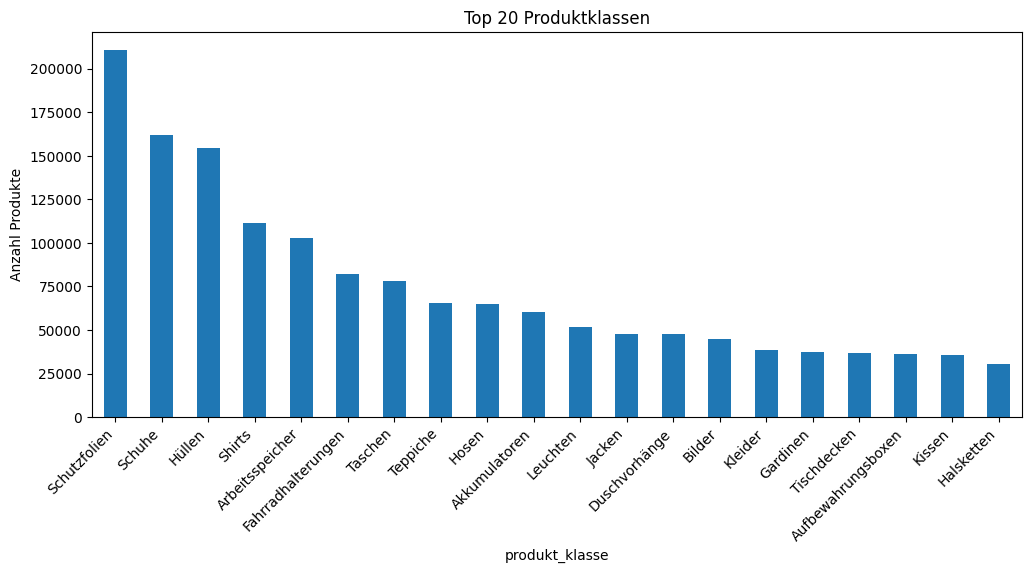

In [47]:
entropy_labels = 0

for i in range(len(vc_rel)):
    p = vc_rel.iloc[i] #iloc ist bei pandas sicherer, weil es nicht auf das Label im Index zugreift, sondern auf die Position (Index kann anders gelabeld sein)
    entropy_labels += p * np.log(p)

entropy_labels = -entropy_labels
entropy_norm = entropy_labels / np.log(len(vc_rel))
print(entropy_labels)
print(entropy_norm)

topk = 20
vc.head(topk).plot(kind="bar", figsize=(12,5))
plt.ylabel("Anzahl Produkte")
plt.title(f"Top {topk} Produktklassen")
plt.xticks(rotation=45, ha="right")
plt.show()

Kurzer Check, ob einige Produkte auch mehr als ein Label haben

## Join von Tabellen Typ und Text
Zu beachten ist, dass die Tabelle Typ mehr Einträge beinhaltet als die Tabelle Text

In [ ]:
df_txt_clean["produkt_id"] = df_txt_clean["produkt_id"].astype("string") #Typ Casting auf String
df_typ["produkt_id"]      = df_typ["produkt_id"].astype("string") # Type Casting auf String

df_join = df_txt_clean.merge(
    df_typ,
    on="produkt_id",
    how="inner",        # nur Produkte behalten, die in beiden Dateien vorkommen
    validate="m:1"      # viele Texte (m), ein Label (1)
)

df_txt_clean = df_txt_clean[df_txt_clean["beschreibung"].str.len().ge(10)]

print("Zeilen nach Join:", len(df_join))
print("Anteil ohne Label:", df_join["produkt_klasse"].isna().mean())
df_join.head()
df_join = df_join[df_join["beschreibung"].str.len().ge(10)].copy() #Länge von 10 Anwenden auf df_join


Zeilen nach Join: 1996748
Anteil ohne Label: 0.0


,produkt_id,variation_id,beschreibung,desc_len,produkt_klasse
0,S0O0Z0F3,S0O0Z0F3XNK8,-,1,Blusen
1,S0Z0H0DJ,S0Z0H0DJYFCH,home wohnideen schiebevorhang digitaldruck bam...,1060,Gardinen
2,S0J1B062,S0J1B0620136,leggings für alle die wissen worauf es ankommt...,363,Hosen
3,S0I010JR,S0I010JRN3AA,bruchfeste apple iphone 6 silikon hülle im all...,999,Hüllen
4,S041B01K,S041B01K7KAI,maxi-rock aus leinen in a-linie mit wickelopti...,190,Röcke


## Vorbereitung des Baseline-Models (Bag of Words) ##

**1. Prüfung, ob seltene Klassen vorliegen (wg. Train-Test-Split)**

In [55]:
vc = df_join["produkt_klasse"].astype("string").value_counts()
display(vc.tail(10))  # zeigt die seltensten 10 Klassen
vc.min(), (vc == 1).sum()

produkt_klasse
Schutzvisiere                               1
Zeitschaltuhren                             1
Bausteine                                   1
Nägel                                       1
Brustwarzenabdeckungen                      1
Verdünnungsmittel                           1
Rüttelplatten                               1
Bettwarenzubehör                            1
Armaturkartuschen                           1
31_11_Dekokissen_Sitzkissen_Kissenhüllen    1
Name: count, dtype: Int64

(np.int64(1), np.int64(121))

**2. Entferne Klassen mit nur einem Produkt, damit Stratifizierung möglich ist**

In [59]:
vc = df_join["produkt_klasse"].astype("string").value_counts()
min_count = 2  # ggf. strenger setzen, siehe Hinweis unten
keep = df_join["produkt_klasse"].map(vc) >= min_count
df_base = df_join.loc[keep, ["beschreibung", "produkt_klasse"]].copy()
print("Min class count nach Filter:", df_base["produkt_klasse"].value_counts().min())

Min class count nach Filter: 2


**3. Train-Test-Split**

In [60]:
# 3) Train/Test-Split AUF df_base (und stratify passend zu y!)
from sklearn.model_selection import train_test_split

X = df_base["beschreibung"]
y = df_base["produkt_klasse"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

**4. Bag of Words Model**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=10_000)
X_train_bow = bow.fit_transform(X_train) # Lernt das Vokabular (10.000 häufigste Wörter)
X_test_bow = bow.transform(X_test)